In [4]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
!unzip -qq ECG5000.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 32.7MB/s]


In [5]:
!pip install -q liac-arff

  Preparing metadata (setup.py) ... done


In [6]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from glob import glob
import time
import copy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Set Random Seeds for Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Load and preprocess the dataset
with open('ECG5000_TRAIN.arff', 'r') as f:
    train = arff.load(f)
train = pd.DataFrame(train['data'], columns=[attr[0] for attr in train['attributes']])

with open('ECG5000_TEST.arff', 'r') as f:
    test = arff.load(f)
test = pd.DataFrame(test['data'], columns=[attr[0] for attr in test['attributes']])


In [10]:
df = pd.concat([train, test], ignore_index=True)
df = df.sample(frac=1.0)
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1501,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2586,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2653,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
1055,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
705,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [11]:
CLASS_NORMAL = 1
class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)

In [12]:
# Normalize sequences
scaler = MinMaxScaler(feature_range=(0, 1))
normal_df = pd.DataFrame(scaler.fit_transform(normal_df))
anomaly_df = pd.DataFrame(scaler.transform(anomaly_df))

train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size=0.15, random_state=RANDOM_SEED)

train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

In [13]:
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1) for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

train_dataset, seq_len, n_features = create_dataset(train_sequences)
val_dataset, _, _ = create_dataset(val_sequences)
test_normal_dataset, _, _ = create_dataset(test_sequences)
test_anomaly_dataset, _, _ = create_dataset(anomaly_sequences)

In [14]:
# Model Definition
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(input_size=n_features, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(p=0.3)  # Added dropout
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim, hidden_size=embedding_dim, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(p=0.3)  # Added dropout

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x = self.dropout1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [15]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(input_size=input_dim, hidden_size=input_dim, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(p=0.3)  # Added dropout
        self.rnn2 = nn.LSTM(input_size=input_dim, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(p=0.3)  # Added dropout
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x = self.dropout1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = self.dropout2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [16]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [18]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [19]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs=10)

Epoch 1: train loss 16.32565715571461 val loss 14.303111025082167
Epoch 2: train loss 14.19967161460732 val loss 13.71125114861355
Epoch 3: train loss 13.922100005636096 val loss 13.41845743374158
Epoch 4: train loss 13.618717476899755 val loss 13.237914867298578
Epoch 5: train loss 13.139098920825987 val loss 11.194612062105568
Epoch 6: train loss 11.299730089872607 val loss 11.559236854635259
Epoch 7: train loss 11.11044439756308 val loss 10.593489386702096
Epoch 8: train loss 10.896623910410373 val loss 10.363178653101768
Epoch 9: train loss 10.561405278943518 val loss 10.091322498936806
Epoch 10: train loss 11.976255787615331 val loss 11.453948276017302


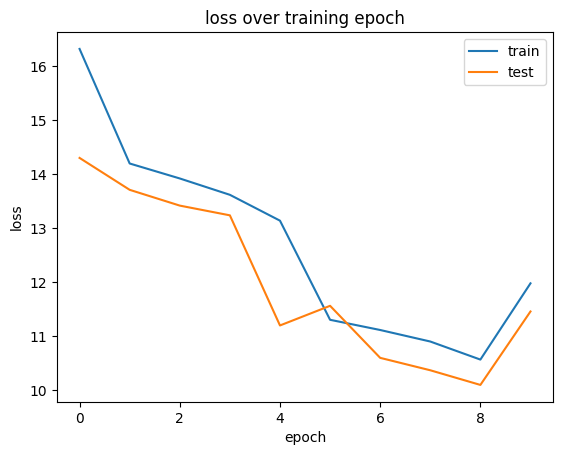

In [20]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.title('loss over training epoch')
plt.show()

In [21]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [22]:
# Automated Threshold Determination
_, train_losses = predict(model, train_dataset)
THRESHOLD = np.mean(train_losses) + 3 * np.std(train_losses)
print(f'Calculated threshold: {THRESHOLD}')
THRESHOLD = int(22)

Calculated threshold: 28.379608603944256


Correct normal predictions: 65/66


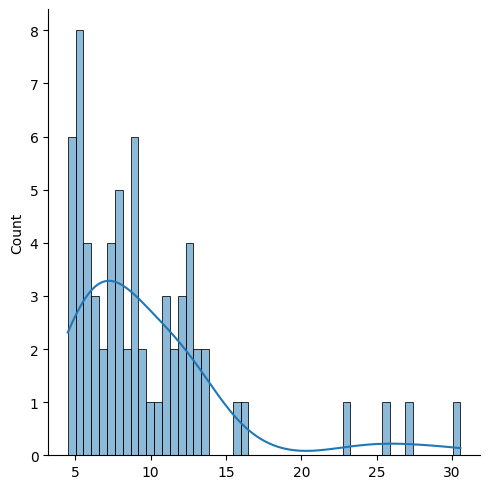

In [23]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.displot(pred_losses, bins=50, kde=True)
normal_correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {normal_correct}/{len(test_normal_dataset)}')

Correct anomaly predictions: 1955/2081


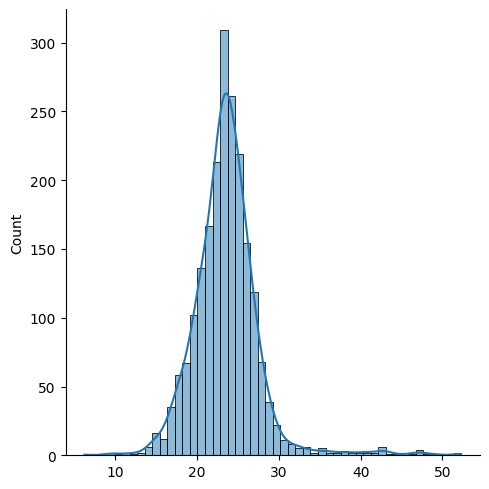

In [27]:
predictions, anomaly_losses = predict(model, test_anomaly_dataset)
sns.displot(anomaly_losses, bins=50, kde=True)
anomaly_correct = sum(l <= THRESHOLD for l in anomaly_losses)
print(f'Correct anomaly predictions: {anomaly_correct}/{len(test_anomaly_dataset)}')


In [34]:
# Evaluation Metrics
# Number of correct predictions
normal_correct = 65  # example count of correctly predicted normal data
anomaly_correct = 1957  # example count of correctly predicted anomaly data

# Total number of test samples
normal_total = len(test_normal_dataset)  # length of normal test data
anomaly_total = len(test_anomaly_dataset)  # length of anomalous test data

# True labels: 0 for normal data, 1 for anomalous data
y_true = [0] * normal_total + [1] * anomaly_total

# Predicted labels:
# For normal data: We know 'normal_correct' are correctly predicted as 0, rest as 1
# For anomaly data: We know 'anomaly_correct' are correctly predicted as 1, rest as 0
normal_predictions = [0] * normal_correct + [1] * (normal_total - normal_correct)
anomaly_predictions = [1] * anomaly_correct + [0] * (anomaly_total - anomaly_correct)

# Concatenate the predicted labels
y_pred = normal_predictions + anomaly_predictions

# Ensure the lengths match
assert len(y_true) == len(y_pred), f"Length mismatch: y_true has {len(y_true)} and y_pred has {len(y_pred)}"

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, [*pred_losses, *anomaly_losses])
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate accuracy
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
print(f"\nAccuracy: {accuracy:.4f}")

# You can also add a summary section for quick reference
print("\nEvaluation Summary:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")

Confusion Matrix:
[[  65    1]
 [ 124 1957]]

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.98      0.51        66
           1       1.00      0.94      0.97      2081

    accuracy                           0.94      2147
   macro avg       0.67      0.96      0.74      2147
weighted avg       0.98      0.94      0.95      2147

ROC-AUC Score: 0.9516

Accuracy: 0.9418

Evaluation Summary:
Accuracy: 0.9418
ROC-AUC: 0.9516
Confusion Matrix: 
[[  65    1]
 [ 124 1957]]
